# Introduction

Fortunately, with libraries such as Scikit-Learn, it’s now easy to build and use almost any machine learning algorithm. But it’s helpful to have an idea of how a machine learning model works under the hood. This lets us diagnose the model when it’s underperforming or explain how it makes decisions, which is crucial if we want to convince others to trust our models.
In this assignment, we’ll look at how to build and use the Decision Tree and the Random Forest in Python. We’ll start by understanding how a single decision tree makes classifications on a simple problem. Then, we’ll work our way to using a random forest on a real-world data science problem.

# Dataset

The dataset we will use in this assignment is the Sonar dataset.

This is a dataset that describes sonar chirp returns bouncing off different surfaces. The 60 predictors are the strength of the returns at different angles. It is a binary classification problem that requires a model to differentiate rocks from metal cylinders. There are 208 observations.

It is a well-understood dataset. All of the variables are continuous and generally in the range of 0 to 1. The output variable is a string “M” for mine and “R” for rock, which will need to be converted to integers 1 and 0.

By predicting the class with the most observations in the dataset (M or mines) the Zero Rule Algorithm can achieve an accuracy of 53%.

You can learn more about this dataset at the UCI Machine Learning repository.
https://archive.ics.uci.edu/ml/datasets/Connectionist+Bench+(Sonar,+Mines+vs.+Rocks)

Download the dataset for free and place it in the "data" folder in your working directory with the filename sonar.all-data.csv.

# Import section

In [406]:
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn import tree

from tqdm.notebook import tqdm
from tabulate import tabulate
from joblib import Parallel, delayed

# be careful - it's only seed, not random state :)
np.random.seed(2020)
random.seed(2020)

# Preprocess data

Read data and convert targets to integers 1 and 0.

In [407]:
PATH = 'data/'
df = pd.read_csv(PATH+'sonar-all-data.csv', header=None)
df.columns = [f'feat_{col}' if col!=60 else 'target' for col in df.columns]
df['target'] = df['target'].map({'M': 1, 'R': 0})
df.head()

,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,...,feat_51,feat_52,feat_53,feat_54,feat_55,feat_56,feat_57,feat_58,feat_59,target
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,0
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,...,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,0
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,0
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,...,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,0
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,...,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,0


# Split data (train and test)

In [408]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='target'), df['target'], test_size=0.2, random_state=2020)

In [409]:
print(X_train.shape, X_test.shape)

(166, 60) (42, 60)


# Cost functions

In this section you should implement two cost functions. Any of these can be used in the model.

## Gini index

In [410]:
def gini_index(x):
    """ Calculate Gini Index for a node
    Args:
        x: Numpy-array of targets in a node
    Returns:
        float: Gini index
    """    
    if len(x) == 0:
        return 0.0
    p = np.bincount(x) / len(x)
    return 1 - np.sum(p*p)

In [411]:
target = df['target'].values
gini_index(target)

0.4977348372781065

In [412]:
def gini_gain(parent_node, splits):
    """ Calculate Gini Gain for a particular split
    Args:
        parent_node: Numpy-array of targets in a parent node
        splits: List of two numpy-arrays. Each numpy-array is targets in a child node
    Returns:
        float: Gini gain
    """       
    splits_gini = np.sum([gini_index(split)*(len(split)/len(parent_node)) for split in splits])
    return gini_index(parent_node) - splits_gini

In [413]:
splits = [np.random.choice(df['target'].values, 100), np.random.choice(df['target'].values, 108)]
gini_gain(target, splits)

-0.0003705758273065962

## Entropy

In [414]:
def entropy(x):
    """ Calculate Entropy for a node
    Args:
        x: Numpy-array of targets in a node
    Returns:
        float: Entropy
    """
    if len(x) == 0:
        return 0.0
    p = np.clip(np.bincount(x) / len(x), 1e-15, 1.)
    return -np.sum(p * np.log(p))

In [415]:
def information_gain(parent_node, splits):
    """ Calculate Information Gain for a particular split
    Args:
        parent_node: Numpy-array of targets in a parent node
        splits: List of two numpy-arrays. Each numpy-array is targets in a child node
    Returns:
        float: Information Gain
    """     
    splits_entropy = np.sum([entropy(split)*(len(split)/len(parent_node)) for split in splits])
    return entropy(parent_node) - splits_entropy

In [416]:
splits = [np.random.choice(df['target'].values, 100), np.random.choice(df['target'].values, 108)]
information_gain(target, splits)

-0.00131193512579042

Некоторые вычисления для quiz-а

In [417]:
parent_node_entropy = -11/20 * np.log(11/20) - 9/20 * np.log(9/20)
print(parent_node_entropy)

0.6881388137135884


In [418]:
first_split_entropy = 13/20 * (-5/13 * np.log(5/13) - 8/13 * np.log(8/13)) + \
                      7/20 * (-6/7 * np.log(6/7) - 1/7 * np.log(1/7)) 
print(first_split_entropy, parent_node_entropy - first_split_entropy)

0.5766216989704825 0.11151711474310588


In [419]:
second_split_entropy = 9/20 * (-2/9 * np.log(2/9) - 7/9 * np.log(7/9)) + \
                      11/20 * (-9/11 * np.log(9/11) - 2/11 * np.log(2/11))
print(second_split_entropy, parent_node_entropy - second_split_entropy)                               

0.4991444117577551 0.18899440195583334


In [420]:
np.round(0.18899440195583334, 3)

0.189

In [421]:
gini_impurity_parent = 1 - (11/20)**2 - (9/20)**2
print(gini_impurity_parent)

0.495


In [422]:
first_split_gini = 13/20 * (1 - (5/13) **2 - (8/13) ** 2) + \
                   7/20 * (1 - (6/7) **2 - (1/7) ** 2) 
print(first_split_gini, gini_impurity_parent - first_split_gini)

0.39340659340659345 0.10159340659340654


In [423]:
second_split_gini = 9/20 * (1 - (2/9) ** 2 - (7/9) **2) + \
                    11/20 * (1 - (9/11) ** 2 - (2/11) ** 2)
print(second_split_gini, gini_impurity_parent - second_split_gini)    

0.31919191919191914 0.17580808080808086


In [424]:
np.round(0.17580808080808086, 3)

0.176

# Split function

Implement split functions

In [425]:
def split(X, y, value):
    """ Split y-values in order to calculate gain later
    Args:
        X: 1-dimensional numpy-array of data predictor with shape (N,)
        y: 1-dimensional numpy-array of targets with shape (N,)
        value (float): the value by which the X should be splitted
    Returns:
        Two 1-dimensional numpy-arrays with targets related to splits
    """      
    left_mask = X < value
    right_mask = X >= value
    return y[left_mask], y[right_mask]


def split_dataset(X, y, column, value):
    """ Split dataset by a particular column and value
    Args:
        X: 2-dimensional numpy-array (N, num_feats). N-number of samples
        y: 1-dimensional numpy-array of targets with shape (N,)  
        column (int): the column by which the X should be splitted
        value (float): the value by which the column should be splitted
    Returns:
        Two 2-dimensional numpy-arrays with data and two 1-dimensional numpy-arrays with targets related to splits
        left_X, right_X, left_y, right_y
    """       
    left_mask = X[:, column] < value
    right_mask = X[:, column] >= value
    left_y, right_y = y[left_mask], y[right_mask]
    left_X, right_X = X[left_mask], X[right_mask]
    return left_X, right_X, left_y, right_y

# Decision tree

In [426]:
class Tree(object):
    """A decision tree classifier.

    Args:
        criterion : {"gini_gain", "information_gain"}
    """
    def __init__(self, criterion=None):
        self.impurity = None
        self.threshold = None
        self.column_index = None
        self.outcome_probs = None
        self.criterion = criterion
        self.left_child = None
        self.right_child = None

    @property
    def is_terminal(self):
        """ Define is it terminal node
        """          
        return not bool(self.left_child or self.right_child)

    def _find_splits(self, X):
        """Find all possible split values."""
        split_values = set()

        # Get unique values in a sorted order
        x_unique = list(np.unique(X))
        for i in range(1, len(x_unique)):
            # Find a point between two values
            average = (x_unique[i - 1] + x_unique[i]) / 2.0
            split_values.add(average)

        return list(split_values)

    def _find_best_split(self, X, y, n_features):
        """Find best feature and value for a split. Greedy algorithm."""

        # Sample random subset of features
        subset = random.sample(list(range(0, X.shape[1])), n_features)
        max_gain, max_col, max_val = None, None, None

        for column in subset:
            split_values = self._find_splits(X[:, column])
            for value in split_values:
                splits = split(X[:, column], y, value)
                gain = self.criterion(y, splits)

                if (max_gain is None) or (gain > max_gain):
                    max_col, max_val, max_gain = column, value, gain
        return max_col, max_val, max_gain

    def fit(self, X, y, n_features, max_depth):
        """Fit model.

        Args:
            X (numpy-array): The training input samples. 2-dimensional numpy array.
            y (numpy-array): The target values. 1-dimensional numpy array.
            n_features (int): The number of features when fit is performed (default: all features)
            max_depth (int): The maximum depth of the tree. If None, then nodes are expanded until
                             all leaves are pure.
        """        
        try:
            # Exit from recursion using assert syntax
            if max_depth is not None:
                assert max_depth > 0
                max_depth -= 1

            if n_features is None:
                n_features = X.shape[1]

            column, value, gain = self._find_best_split(X, y, n_features)
            assert gain is not None

            self.column_index = column
            self.threshold = value
            self.impurity = gain

            # Split dataset
            left_X, right_X, left_target, right_target = split_dataset(X, y, column, value)

            # Grow left and right child
            self.left_child = Tree(self.criterion)
            self.left_child.fit(
                left_X, left_target, n_features, max_depth
            )

            self.right_child = Tree(self.criterion)
            self.right_child.fit(
                right_X, right_target, n_features, max_depth
            )
        except AssertionError:
            self.outcome_probs = np.around(np.sum(y) / y.shape[0])


    def predict_row(self, row):
        """Predict single row."""
        if not self.is_terminal:
            if row[self.column_index] < self.threshold:
                return self.left_child.predict_row(row)
            else:
                return self.right_child.predict_row(row)
        return self.outcome_probs

    def predict(self, X):
        """Make predictions.

        Args:
            X (numpy-array): The test input samples. 2-dimensional numpy array.
        """  
        result = np.zeros(X.shape[0])
        for i in range(X.shape[0]):
            result[i] = self.predict_row(X[i, :])
        return result

Let's fit two models with "max_depth=3" and "max_depth=None" hyperparameters.

In [427]:
model = Tree(criterion=gini_gain)
model.fit(X_train.values, y_train.values, None, None)
y_pred = model.predict(X_test.values)
print(f"Accuracy score is: {accuracy_score(y_test, y_pred)}")

Accuracy score is: 0.6666666666666666


In [428]:
model = Tree(criterion=gini_gain)
model.fit(X_train.values, y_train.values, n_features=None, max_depth=3)
y_pred = model.predict(X_test.values)
print(f"Accuracy score is: {accuracy_score(y_test, y_pred)}")

Accuracy score is: 0.6666666666666666


In [429]:
model = Tree(criterion=information_gain)
model.fit(X_train.values, y_train.values, n_features=None, max_depth=3)
y_pred = model.predict(X_test.values)
print(f"Accuracy score is: {accuracy_score(y_test, y_pred)}")

Accuracy score is: 0.7380952380952381


In [430]:
standard_model = tree.DecisionTreeClassifier(criterion='gini', max_depth=3)
standard_model.fit(X_train.values, y_train.values)
y_pred = standard_model.predict(X_test.values)
print(f"Accuracy score is: {accuracy_score(y_test, y_pred)}")

Accuracy score is: 0.6666666666666666


In [431]:
standard_model = tree.DecisionTreeClassifier(criterion='entropy', max_depth=3)
standard_model.fit(X_train.values, y_train.values)
y_pred = standard_model.predict(X_test.values)
print(f"Accuracy score is: {accuracy_score(y_test, y_pred)}")

Accuracy score is: 0.7380952380952381


# Random forest

In [432]:
class MyRandomForestClassifier(object):
    """
    A random forest classifier.
    A random forest is a meta estimator that fits a number of decision tree
    classifiers on various sub-samples of the dataset and uses averaging to
    improve the predictive accuracy and control overfitting.
    
    Args:
        n_estimators : int, default=10
            The number of trees in the forest.

        max_depth : int, default=None
            The maximum depth of the tree. If None, then nodes are expanded until
            all leaves are pure.        

        n_features : int, default=None
            The number of features to consider when looking for the best split.
            If None, then `n_features=sqrt(n_features)`.

        criterion : {"gini", "entropy"}, default="gini"
            The function to measure the quality of a split. Supported criteria are
            "gini" for the Gini impurity and "entropy" for the information gain.
            
        bootstrap : bool, default = True
            Perform bootstrapping on X
        
        n_jobs : int, default = 1
            Num of processes used to fit trees in forest
    """

    def __init__(self, n_estimators=10, max_depth=None, n_features=None, criterion="entropy", bootstrap=True, n_jobs = 1):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.n_features = n_features
        self.bootstrap = bootstrap
        self.n_jobs = n_jobs
        
        if criterion == "entropy":
            self.criterion = information_gain
        elif criterion == "gini":
            self.criterion = gini_gain
        else:
            raise ValueError(f"Unknown criterion '{criterion}'")
            
        self.trees = [Tree(criterion=self.criterion) for _ in range(n_estimators)]
        
    def _init_data(self, X, y):
        """Ensure data are in the expected format.
        Ensures X and y are stored as numpy ndarrays by converting from an
        array-like object if necessary. 
        Parameters
        Args:
            X : array-like
                Feature dataset.
            y : array-like, default=None
                Target values
        """
        self.size = len(X)
        
        if not isinstance(X, np.ndarray):
            self.X = np.array(X)
        else:
            self.X = X

        if not isinstance(y, np.ndarray):
            self.y = np.array(y)
        else:
            self.y = y
            
    def bootstrap_data(self, size):
        return np.random.randint(size, size=size)
    
    def _fit_one_tree(self, tree):
        if self.bootstrap:
            idxs = self.bootstrap_data(self.size)
            X = self.X[idxs]
            y = self.y[idxs]
        else:
            X = self.X
            y = self.y
                
        tree.fit(
                  X,
                  y,
                  n_features=self.n_features,
                  max_depth=self.max_depth)
        return tree
    
    def fit(self, X, y):
        """Fit model.

        Args:
            X (numpy-array): The training input samples. 2-dimensional numpy array.
            y (numpy-array): The target values. 1-dimensional numpy array.
        """         
        if self.n_features is None:
            self.n_features = int(np.sqrt(X.shape[1]))
        elif X.shape[1] < self.n_features:
            raise ValueError(f"'n_features should be <= n_features'")
            
        self._init_data(X, y)
        
        self.fitted_trees = Parallel(n_jobs=self.n_jobs, prefer='processes')(delayed(self._fit_one_tree)(tree) for tree in self.trees)
        self.trees = self.fitted_trees
        self.fitted_trees = None
        
        #for tree in self.trees:
        #    self._fit_one_tree(tree)
       
            
    def predict(self, X):
        """Make predictions.

        Args:
            X (numpy-array): The test data input samples. 2-dimensional numpy array.
        """            
        if not isinstance(X, np.ndarray):
            X = np.array(X)

        if self.X is not None:
            predictions = np.zeros(len(X))
            for i in range(len(X)):
                row_pred = 0.
                for tree in self.trees:
                    row_pred += tree.predict_row(X[i, :])

                row_pred /= self.n_estimators
                predictions[i] = round(row_pred)
            return predictions  
        else:
            raise ValueError("You should fit a model before `predict`")

Fit two models with "n_estimators=10" and "n_estimators=100" hyperparameters

In [433]:
model = MyRandomForestClassifier(n_estimators=10, max_depth=None, n_features=None, criterion="entropy", n_jobs=4)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(f"Accuracy score is: {accuracy_score(y_test, y_pred)}")

Accuracy score is: 0.8095238095238095


In [434]:
model = MyRandomForestClassifier(n_estimators=100, max_depth=None, n_features=None, criterion="entropy", n_jobs=4)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(f"Accuracy score is: {accuracy_score(y_test, y_pred)}")

Accuracy score is: 0.8809523809523809


Now it's your turn to explore the various parameters of sklearn [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) and their influence on model quality.

# Homework part 1. RandomForestClassifier

_Note_: Consider **accuracy** as main metric of model performance on this dataset.

In [435]:
from sklearn.ensemble import RandomForestClassifier

**Task 1 (0.5 points)** Split the dataset into train, test and validation parts (0.6 / 0.2 / 0.2). First two will be used for model hyperparameter tuning whereas the best model quality should be evaluated on validation part.

In [436]:
# let's use train_test_split twice - first 0.4 of original dataset to test+val, then half of test to validation part
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='target'), df['target'], test_size=0.4, random_state=123)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=123)

In [437]:
print(X_train.shape, X_test.shape, X_val.shape)

(124, 60) (42, 60) (42, 60)


In [438]:
# quick check that we haven't lost indexes
total = list(X_train.index) + list(X_test.index) + list(X_val.index)
len(np.unique(total))

208

**Task 2 (2 points)**. Apply '_greedy_' hyperparameter tuning of RandomForestClassifier model. '_Greedy_' way means the following general approach. At first we tune one model parameter whereas others are fixed with default values. Then we move on to tune the second parameter whereas others are fixed default values and first has the best values from previous step. After it we tune the third parameter with best fixed values for previous two and default values for the rest. Repeat until we go through all the parameters, then repeat this cycle if you are seeing a clear increase in the test metric. <br>

Although this approach has a lot of disadvantages (you may think which ones), sometimes that is the only way to tune model typerparams due to big training time **if you understand how the model parameters are interrelated and the tuning order takes those dependencies into account.**<br>

Here is one of the possible options for RandomForestClassifier:
- Choose a decent value for number of trees using '_elbow_' rule. You may plot the dependence of accuracy on trees_num and pick up the number after which the error decreases not **as much as before**. 
- Pick up the best split criterion ('gini' / 'entropy') and then tune _max_depth_, _min_samples_split_, _min_samples_leaf_.
- Increase number of trees with best found parameters so far.
- Repeat this excersice starting from picking the best split criterion while other params are fixed with best values from previous steps **if you observe a significant test metric improvement**. Otherwise just stop and measure your best model result on validation set.

In [439]:
def estimate_model(estimators, criterion, max_depth = None, min_samples_split = 2, min_samples_leaf = 1):
    model = RandomForestClassifier(n_estimators=estimators,
                                   criterion=criterion,
                                   max_depth=max_depth,
                                   min_samples_split=min_samples_split,
                                   min_samples_leaf=min_samples_leaf,
                                   random_state=11)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return accuracy_score(y_test, y_pred)

In [440]:
# step 1. 'elbow' rule for number of trees selection

estimators_count_grid = np.arange(1, 101)
estimators_accuracy = np.zeros(len(estimators_count_grid))

for idx, estimators in enumerate(estimators_count_grid):
    estimators_accuracy[idx] = estimate_model(estimators, criterion="entropy")

In [441]:
print(tabulate(list(enumerate(estimators_accuracy, 1))[:30], headers=['Num of trees', 'Accuracy on test']))

  Num of trees    Accuracy on test
--------------  ------------------
             1            0.547619
             2            0.380952
             3            0.714286
             4            0.642857
             5            0.738095
             6            0.690476
             7            0.785714
             8            0.761905
             9            0.785714
            10            0.785714
            11            0.785714
            12            0.785714
            13            0.833333
            14            0.833333
            15            0.785714
            16            0.809524
            17            0.857143
            18            0.833333
            19            0.880952
            20            0.857143
            21            0.857143
            22            0.857143
            23            0.857143
            24            0.857143
            25            0.857143
            26            0.880952
            27      

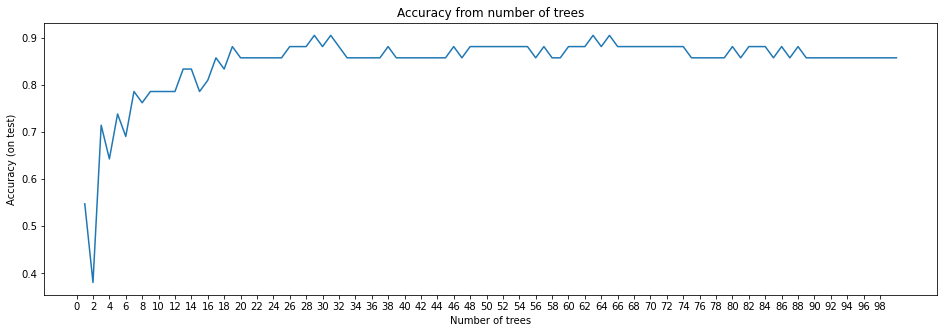

In [442]:
def plot_estimators_accuracy(estimators_count_grid, estimators_accuracy):
    plt.figure(figsize=(16, 5))
    lineplot = sns.lineplot(x=estimators_count_grid, y=estimators_accuracy)
    lineplot.set_title('Accuracy from number of trees')
    lineplot.set_xlabel('Number of trees')
    lineplot.set_ylabel('Accuracy (on test)')
    lineplot.set_xticks(np.arange(0, max(estimators_count_grid), 2.0));

plot_estimators_accuracy(estimators_count_grid, estimators_accuracy)

Looks like about 20 trees or even less is enough (look at tabulate and graph above). Then quality is not increasing that much and fluctuating up and down

In [443]:
NUM_ESTIMATORS = 20

# step 2. 'gini' or 'entropy'?

gini_accuracy = estimate_model(NUM_ESTIMATORS, criterion="gini")
entropy_accuracy = estimate_model(NUM_ESTIMATORS, criterion="entropy")
    
print(f"accuracy. gini: {gini_accuracy}, entropy: {entropy_accuracy}")

accuracy. gini: 0.8095238095238095, entropy: 0.8571428571428571


gini criterion doesn't better than entropy in case of all other parameters fixed

In [444]:
CRITERION = 'entropy'

# step 3. let's tune max_depth now

max_depth_grid = np.arange(1, 20)
estimators_accuracy = np.zeros(len(max_depth_grid))

for idx, depth in enumerate(max_depth_grid):
    estimators_accuracy[idx] = estimate_model(estimators=NUM_ESTIMATORS, criterion=CRITERION, max_depth=depth)

In [445]:
print(tabulate(list(enumerate(estimators_accuracy, 1)), headers=['Max depth of trees', 'Accuracy on test']))

  Max depth of trees    Accuracy on test
--------------------  ------------------
                   1            0.642857
                   2            0.761905
                   3            0.809524
                   4            0.809524
                   5            0.857143
                   6            0.857143
                   7            0.857143
                   8            0.880952
                   9            0.880952
                  10            0.857143
                  11            0.857143
                  12            0.857143
                  13            0.857143
                  14            0.857143
                  15            0.857143
                  16            0.857143
                  17            0.857143
                  18            0.857143
                  19            0.857143


max_depth = 8 gives us maximum

In [446]:
MAX_DEPTH = 8

# step 4. let's tune min_samples_split

min_samples_split_grid = np.arange(2, 20)
estimators_accuracy = np.zeros(len(min_samples_split_grid))

for idx, min_samples_split in enumerate(min_samples_split_grid):
    estimators_accuracy[idx] = estimate_model(estimators=NUM_ESTIMATORS, 
                                              criterion=CRITERION,
                                              max_depth=MAX_DEPTH,
                                              min_samples_split=min_samples_split)

In [447]:
print(tabulate(list(enumerate(estimators_accuracy, 2)), headers=['Min samples split', 'Accuracy on test']))

  Min samples split    Accuracy on test
-------------------  ------------------
                  2            0.880952
                  3            0.880952
                  4            0.904762
                  5            0.833333
                  6            0.857143
                  7            0.809524
                  8            0.833333
                  9            0.833333
                 10            0.809524
                 11            0.833333
                 12            0.833333
                 13            0.833333
                 14            0.833333
                 15            0.809524
                 16            0.809524
                 17            0.809524
                 18            0.809524
                 19            0.809524


In [448]:
MIN_SAMPLES_SPLIT = 4

# step 5. Let's tune min_samples_leaf

min_samples_leaf_grid = np.arange(1, 20)
estimators_accuracy = np.zeros(len(min_samples_leaf_grid))

for idx, min_samples_leaf in enumerate(min_samples_leaf_grid):
    estimators_accuracy[idx] = estimate_model(estimators=NUM_ESTIMATORS, 
                                              criterion=CRITERION,
                                              max_depth=MAX_DEPTH,
                                              min_samples_split=MIN_SAMPLES_SPLIT,
                                              min_samples_leaf=min_samples_leaf)

In [449]:
print(tabulate(list(enumerate(estimators_accuracy, 1))[:10], headers=['Min samples leaf', 'Accuracy on test']))

  Min samples leaf    Accuracy on test
------------------  ------------------
                 1            0.904762
                 2            0.857143
                 3            0.785714
                 4            0.809524
                 5            0.809524
                 6            0.833333
                 7            0.809524
                 8            0.785714
                 9            0.857143
                10            0.809524


In [450]:
MIN_SAMPLES_LEAF = 1

# that was last parameter we tuned
# for sake of the experiment lets repeat first step, but with all other parameters fixed

estimators_count_grid = np.arange(1, 101)
estimators_accuracy = np.zeros(len(estimators_count_grid))

for idx, estimators in enumerate(estimators_count_grid):
    estimators_accuracy[idx] = estimate_model(estimators=estimators, 
                                              criterion=CRITERION,
                                              max_depth=MAX_DEPTH,
                                              min_samples_split=MIN_SAMPLES_SPLIT,
                                              min_samples_leaf=MIN_SAMPLES_LEAF)


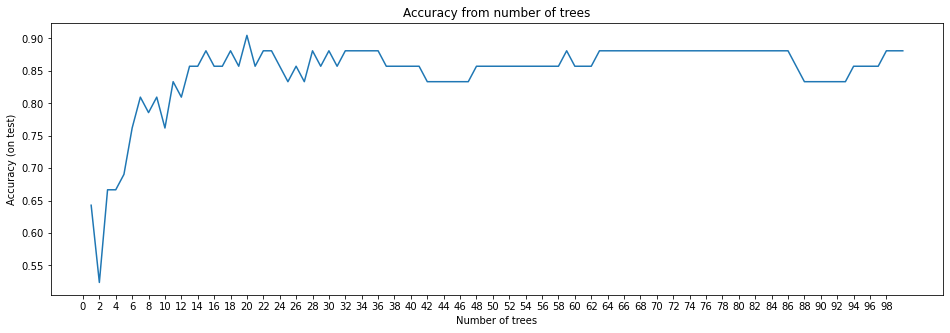

In [451]:
plot_estimators_accuracy(estimators_count_grid, estimators_accuracy)

We see that quality doesn't improve anymore. So let's stop for now.
Good idea right now to check our parameters on validation data.

In [452]:
model = RandomForestClassifier(n_estimators=NUM_ESTIMATORS,
                               criterion=CRITERION,
                               max_depth=MAX_DEPTH,
                               min_samples_split=MIN_SAMPLES_SPLIT,
                               min_samples_leaf=MIN_SAMPLES_LEAF,
                               random_state=11)

model.fit(X_train, y_train)
y_pred = model.predict(X_val)
accuracy_score(y_val, y_pred)

0.7619047619047619

We see quality is significantly dropped on validation data (from 0.9 to 0.76). I tried cycle about several times, choosing different parameters on different steps (sometimes not the best, but close to best). This version is best i got for this kind of search.

Just to look at what we got, let's plot couple of trees from random forest.

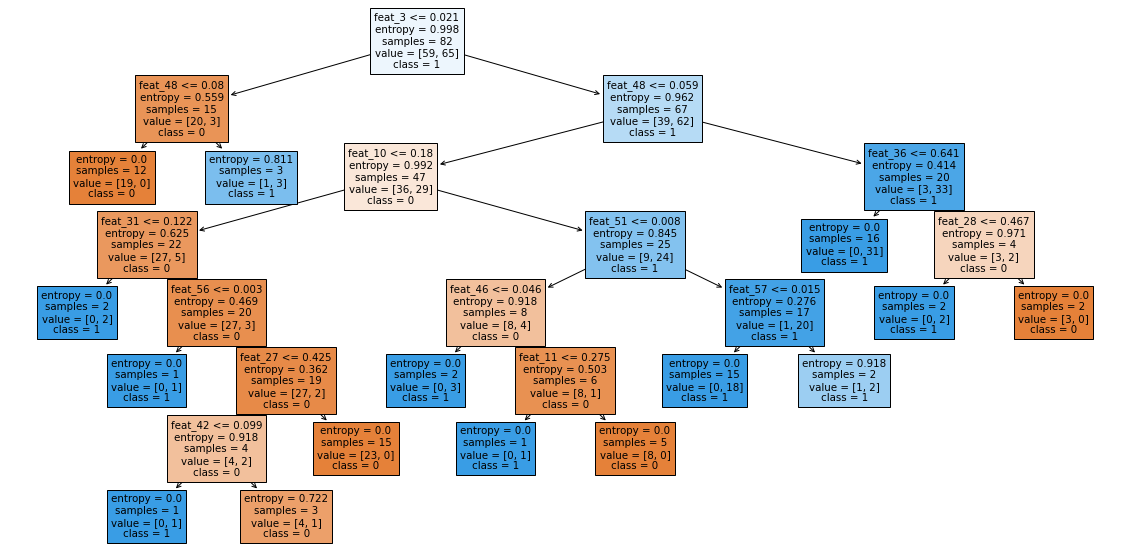

In [453]:
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize=(20, 10))
tree.plot_tree(model.estimators_[0],
               feature_names = X_train.columns, 
               class_names=['0', '1'],
               filled = True);

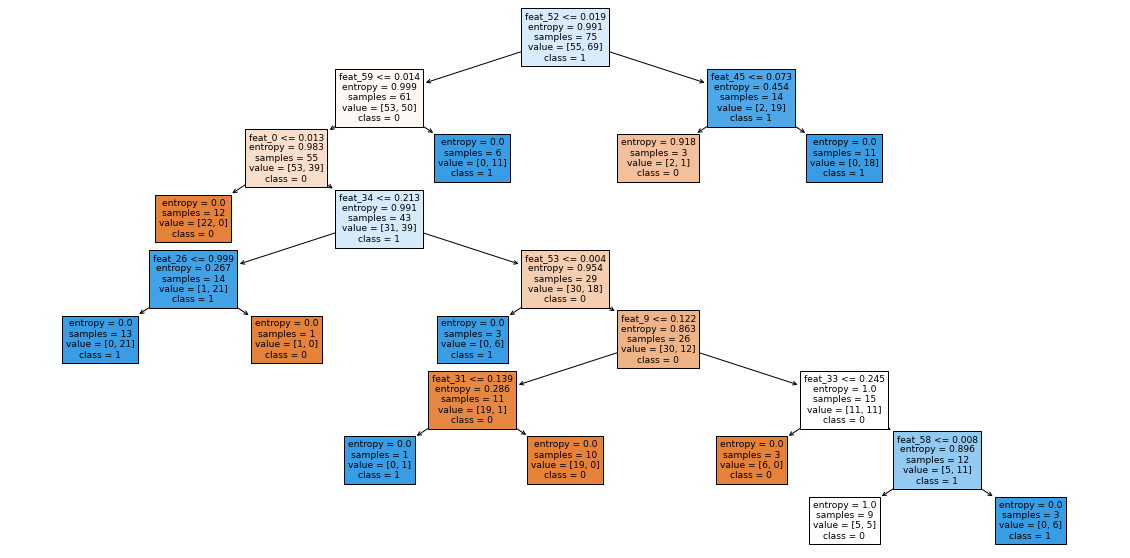

In [454]:
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (20, 10))
tree.plot_tree(model.estimators_[1],
               feature_names = X_train.columns, 
               class_names=['0', '1'],
               filled = True);

### Grid Search and Random Search

If you have enough computational power for model training in a reasonable amount of time more sophisticated approach of hyperparameter tuning would be either Grid Search or Random Search.<br>

In a nutshell Grid Search allows you to pass through all different combinations of given model parameters and their values and choose the best combination. Whereas Random Search would randomly choose values for given model parameters and evaluate them on test data untill it reaches the specified number of iterations.<br>

More information here [Gentle introduction to Grid and Random search](https://medium.com/@senapati.dipak97/grid-search-vs-random-search-d34c92946318) and here [Detailed Explanation with code examples](https://machinelearningmastery.com/hyperparameter-optimization-with-random-search-and-grid-search/).

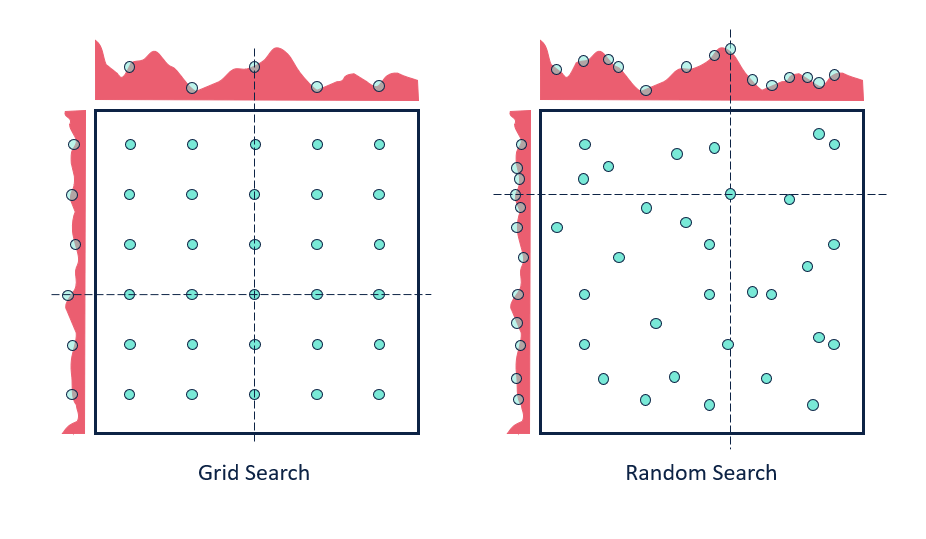

**Task 3 (1 point)**. Compare your previous results with [GridSearch](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) hyperparameter tuning. You may tune best hyperparameters for forest with several trees and then increase it while measure the quality on validation dataset.

I've tried num of trees fixed and equal to 5, 8, 11, 14, 17, 20. For fixed number of trees, i did GridSearchCV 


for trees = 5

{'criterion': 'entropy',
 'max_depth': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2}
 
score on validation: 0.642571428571429


for trees = 8

{'criterion': 'gini',
 'max_depth': None,
 'min_samples_leaf': 3,
 'min_samples_split': 2}
 
score on validation: 0.7142857142857143
 
for trees = 11

{'criterion': 'entropy',
 'max_depth': 7,
 'min_samples_leaf': 2,
 'min_samples_split': 2}

score on validation: 0.7619047619047619

 
for tress = 14

{'criterion': 'entropy',
 'max_depth': 4,
 'min_samples_leaf': 2,
 'min_samples_split': 2}
 
score on validation: 0.7380952380952381

for trees = 17
 
{'criterion': 'entropy',
 'max_depth': 6,
 'min_samples_leaf': 1,
 'min_samples_split': 7}
 
score on validation: 0.7619047619047619
 
for trees = 20

{'criterion': 'gini',
 'max_depth': None,
 'min_samples_leaf': 1,
 'min_samples_split': 7}
 
 0.7619047619047619
 

In [455]:
# Your code here

NUM_TREES = 20

grid_params = {'criterion': ['entropy', 'gini'],
              'max_depth': [None, 1, 2, 3, 4, 5, 6, 7],
              'min_samples_split': np.arange(2, 11),
              'min_samples_leaf' : np.arange(1, 11)}


rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=11 + NUM_TREES)

model = RandomForestClassifier(n_estimators=NUM_TREES, random_state=11 + NUM_TREES)
model_search = GridSearchCV(model, grid_params, scoring='accuracy', n_jobs=-1, refit=True, cv=rskf)

X_train_plus_test = pd.concat([X_train, X_test])
y_train_plus_test = pd.concat([y_train, y_test])

model_search.fit(X_train_plus_test, y_train_plus_test)

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=5, random_state=31),
             estimator=RandomForestClassifier(n_estimators=20, random_state=31),
             n_jobs=-1,
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': [None, 1, 2, 3, 4, 5, 6, 7],
                         'min_samples_leaf': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
                         'min_samples_split': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10])},
             scoring='accuracy')

In [456]:
model_search.best_params_

{'criterion': 'gini',
 'max_depth': None,
 'min_samples_leaf': 1,
 'min_samples_split': 7}

In [457]:
y_pred = model_search.predict(X_val)
accuracy_score(y_val, y_pred)

0.7619047619047619

We see from experiment, that we achieved the same quality as with greedy algorithm.
I haven't searched by grid search for num of trees - it's another possibilty, which could give us better result as well.

**Task 4 (1 point)**. And finally tune forest hyperparameters with [RandomSearch](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html). Compare results to previous attempts.

In [458]:
# Your code here
grid_params = {'n_estimators': np.arange(1, 20),
               'criterion': ['entropy', 'gini'],
               'max_depth': [None] + list(np.arange(1,21)),
               'min_samples_split': np.arange(2, 21),
               'min_samples_leaf' : np.arange(1, 21)}


rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=11)

model = RandomForestClassifier(random_state=11)
model_search = RandomizedSearchCV(model, grid_params, scoring='accuracy', n_iter=10, n_jobs=-1, refit=True, cv=rskf)

X_train_plus_test = pd.concat([X_train, X_test])
y_train_plus_test = pd.concat([y_train, y_test])

model_search.fit(X_train_plus_test, y_train_plus_test)

y_pred = model_search.predict(X_val)
accuracy_score(y_val, y_pred)

0.6904761904761905

In [459]:
print(model_search.best_estimator_)

RandomForestClassifier(criterion='entropy', max_depth=20, min_samples_leaf=8,
                       n_estimators=16, random_state=11)


I've tried search with 10 iterations - it gave worse result than GridSearchCV on validation - 0.69. But if we increase num of iterations - quality on validation will decrease with more iterations we try

**Task 5 (0.5 points)**. Tell us about your experience in hyperparameter tuning with the approaches above. What do you think would be the best option for this task and why?

In greedy optimization i liked possibility to choose parameters on every step - based on tabular or graph data.
GridSearchCV and RandomizedSearchCV are much easier to code, than greedy approach.
RandomizedSearchCV is good when time for optimization of hyper parameters is limited. As Sonar dataset is very small (only 208 examples), i think best option to apply here is GridSearchCV.

### Desicion tree explained

Remember the [Titanic](https://www.kaggle.com/c/titanic) competition from last week? Wouldn't be a good idea to visualize one of possible decision-making processes of _survived_ / _dead_ labeling?

**Task 6 (1 point)**. Load titanic dataset, split it into train/test parts, apply simple hyperparameter tuning of [DesicionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) (use one of the approaches above) in order to have **test accuracy more than 0.65**. <br>

Draw the best tree decision making process. You may use [sklearn.tree.prot_tree](https://scikit-learn.org/stable/modules/generated/sklearn.tree.plot_tree.html).<br>

In [460]:
from sklearn.tree import DecisionTreeClassifier
import os

In [461]:
age_group = {'Mr.' : 0, 'Miss.' : 1, 'Mrs.' : 2, 'Master' : 3, 'Dr.' : 4, 'Unknown' : 5}

def get_age_group(s):
    for k,v in age_group.items():
        if k in s:
            return v
    return age_group['Unknown']

def clean_data(data):
    data_cleaned = data.copy()
    
    ## calculate AgeGroup and impute mean age for each group
    data_cleaned['AgeGroup'] = data_cleaned['Name'].apply(get_age_group)
    mean_age_group = data_cleaned.groupby(by='AgeGroup')[['Age', 'AgeGroup']].mean()
    joined = data_cleaned.join(mean_age_group, on='AgeGroup', rsuffix='_mean')
    data_cleaned.loc[data_cleaned['Age'].isna(), 'Age'] = joined[data_cleaned['Age'].isna()]['Age_mean']
    ##

    data_cleaned['HasParentsChildrens'] = data_cleaned['Parch'] > 0
    data_cleaned['HasSiblingsSpouses'] = data_cleaned['SibSp'] > 0
    
    data_cleaned = pd.get_dummies(data_cleaned, columns=['Pclass', 'Sex', 'Embarked'], drop_first=True)
    data_cleaned = data_cleaned.drop(columns=['Name', 'Ticket', 'Cabin', 'AgeGroup'])
    if 'Survived' in data_cleaned.columns:
        data_cleaned = data_cleaned.drop(columns=['Survived'])
    
    return data_cleaned

In [462]:
RANDOM_STATE = 33

data = pd.read_csv(os.path.join(PATH, 'titanic', 'train.csv')).set_index('PassengerId')

y = data['Survived']
X = clean_data(data)
    
grid_params = {'criterion': ['entropy', 'gini'],
               'max_depth': list(np.arange(1,5)),
               'min_samples_split': np.arange(2, 21),
               'min_samples_leaf' : np.arange(1, 21)}


rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=11)

dtc_model = DecisionTreeClassifier(random_state=RANDOM_STATE)
model_search = RandomizedSearchCV(dtc_model, grid_params, scoring='accuracy', n_iter=30, n_jobs=-1, refit=True, cv=rskf)

model_search.fit(X, y)
model_search.best_score_

0.8196807063795953

In [463]:
test_data = pd.read_csv(os.path.join(PATH, 'titanic', 'test.csv')).set_index('PassengerId')
test_data.loc[test_data['Fare'].isna(), 'Fare'] = test_data['Fare'].mean()

X_test = clean_data(test_data)
y_test_pred = model_search.predict(X_test)
pd.DataFrame(y_test_pred, index=test_data.index, columns=['Survived']).to_csv('submission_muravyev_decision_tree.csv')

second submission attempt score: 0.77990 on kaggle. I haven't done scaling or some kind of analysis here - just took code from previous homework. first time tree was very deep, so i limited it with max_depth = 4.

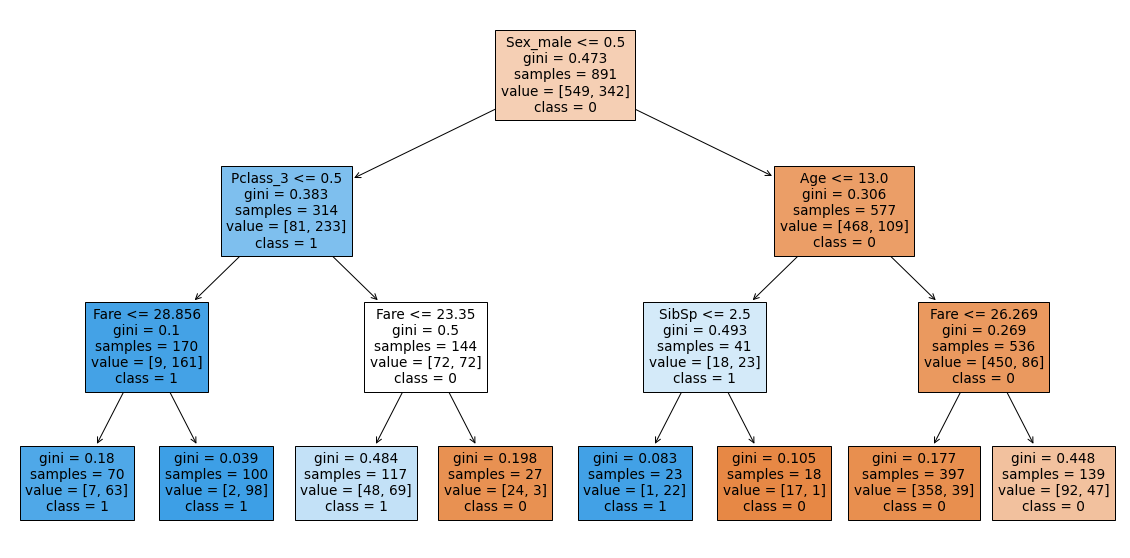

In [464]:
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (20, 10))
tree.plot_tree(model_search.best_estimator_,
               feature_names = X.columns, 
               class_names=['0', '1'],
               filled = True);

Is it easy to interpret its results? Are you able to explain to a random person why would he survive / die on the titanic?

Decision tree explanation is very clear. It detected that sex is most important feature, as well as passenger class and age. So for every passenger we can do easy check with help of this tree.

# Homework part 2. RandomForestRegressor

**Task 7 (2 points)**. Write your own *DecisionTreeRegressor* class with _MSE_ split criterion and settable parameter *max_depth*. Demonstrate its consistency on the proposed artificial data (or some other) by comparing MSE of train predictions with [sklearn.tree.DecisionTreeRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html). <br>

Provide examples for different _max_depth_ parameter.

Of course you may re-use code for *DecisionTreeClassifier*. You need to figure out what needs to be changed in it for Classification -> Regression transformation.<br>

**! You are allowed to use only NumPy library** in this assigment.

I am sorry for a copy-paste of Tree class and changing it. Beatiful generalization of class would require more time.
Changes i made:<br/>
1) sum_of_squared_residuals for different splits<br/>
2) store error instead of impurity<br/>
3) outcome_value instead of outcome_probs - it's mean target value for leaf node<br/>
4) instead of calculation of max information gain, i calculate min error for split<br/>
5) fixed error in is_terminal property - logical condition was incorrect

In [465]:
# it's vectorized operation - minus is for vectors, square is elementwise here
def residuals(split):
    return np.sum((split - np.mean(split)) ** 2) 

def sum_of_squared_residuals(splits):
    """ Calculate sum of squared residuals for a particular split
    Args:
        splits: List of two numpy-arrays. Each numpy-array is target values in a child node
    Returns:
        float: sum of squared difference of value and mean value for split 
    """
    return np.sum([residuals(split) for split in splits])

In [466]:
class MyTreeRegressor(object):
    """A decision tree regressor.

    Args:
        criterion : {"sum_of_squared_residuals""}
    """
    def __init__(self, criterion=None, random_state=None):
        self.error = None
        self.threshold = None
        self.column_index = None
        self.outcome_value = None
        self.criterion = criterion
        self.left_child = None
        self.right_child = None
        self.random_state = random_state

    @property
    def is_terminal(self):
        """ Define is it terminal node
        """          
        return not bool(self.left_child or self.right_child)

    def _find_splits(self, X):
        """Find all possible split values."""
        split_values = set()

        # Get all middle values in a sorted order
        x_unique = np.unique(X)
        split_values = (x_unique[:-1] + x_unique[1:]) / 2
        return list(split_values)

    def _find_best_split(self, X, y, n_features):
        """Find best feature and value for a split. Greedy algorithm."""

        # Sample random subset of features
        random.seed(self.random_state)
        subset = random.sample(list(range(0, X.shape[1])), n_features)
        min_error, min_col, min_val = None, None, None

        for column in subset:
            split_values = self._find_splits(X[:, column])
            for value in split_values:
                splits = split(X[:, column], y, value)
                error = self.criterion(splits)

                if (min_error is None) or (error < min_error):
                    min_col, min_val, min_error = column, value, error
        return min_col, min_val, min_error

    def fit(self, X, y, n_features, max_depth):
        """Fit model.

        Args:
            X (numpy-array): The training input samples. 2-dimensional numpy array.
            y (numpy-array): The target values. 1-dimensional numpy array.
            n_features (int): The number of features when fit is performed (default: all features)
            max_depth (int): The maximum depth of the tree. If None, then nodes are expanded until
                             all leaves are pure.
        """        
        try:
            # Exit from recursion using assert syntax
            if max_depth is not None:
                assert max_depth > 0
                max_depth -= 1

            if n_features is None:
                n_features = X.shape[1]

            column, value, error = self._find_best_split(X, y, n_features)
            assert error is not None

            self.column_index = column
            self.threshold = value
            self.error = error

            # Split dataset
            left_X, right_X, left_target, right_target = split_dataset(X, y, column, value)

            # Grow left and right child
            self.left_child = TreeRegressor(self.criterion)
            self.left_child.fit(
                left_X, left_target, n_features, max_depth
            )

            self.right_child = TreeRegressor(self.criterion)
            self.right_child.fit(
                right_X, right_target, n_features, max_depth
            )
        except AssertionError:
            self.outcome_value = np.mean(y)


    def predict_row(self, row):
        """Predict single row."""
        if not self.is_terminal:
            if row[self.column_index] < self.threshold:
                return self.left_child.predict_row(row)
            else:
                return self.right_child.predict_row(row)
        return self.outcome_value

    def predict(self, X):
        """Make predictions.

        Args:
            X (numpy-array): The test input samples. 2-dimensional numpy array.
        """  
        result = np.zeros(X.shape[0])
        for i in range(X.shape[0]):
            result[i] = self.predict_row(X[i, :])
        return result

In [467]:
import numpy as np

def f(X):
    return X[:, 0]**3 + np.log(np.exp(X[:, 1]) + np.exp(X[:, 2])) + np.sqrt(abs(X[:, 3])) * X[:, 4]

n_samples = 100

stdv = 1. / np.sqrt(5)

X = np.random.uniform(-stdv, stdv, size = (n_samples, 5))
y = f(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11)

In [468]:
def check_regressor(max_depth=None):
    tree_regressor = MyTreeRegressor(criterion = sum_of_squared_residuals, random_state = 43)
    tree_regressor.fit(X_train, y_train, n_features=None, max_depth=max_depth)
    y_pred = tree_regressor.predict(X_test)
    print(f"Depth: {max_depth}. MSE is: {mean_squared_error(y_test, y_pred)}")

check_regressor()
for i in range(1,11):
    check_regressor(i)

Depth: None. MSE is: 0.011361721357076573
Depth: 1. MSE is: 0.033794793392931954
Depth: 2. MSE is: 0.024348061749696767
Depth: 3. MSE is: 0.012053408246915856
Depth: 4. MSE is: 0.01113770845158283
Depth: 5. MSE is: 0.010863113592870377
Depth: 6. MSE is: 0.012986584389578882
Depth: 7. MSE is: 0.010267320714519126
Depth: 8. MSE is: 0.012709679891595748
Depth: 9. MSE is: 0.01290871765414894
Depth: 10. MSE is: 0.011744777685945208


In [469]:
from sklearn.tree import DecisionTreeRegressor

def check_standard_regressor(max_depth = None):
    standard_tree_regressor = DecisionTreeRegressor(criterion = 'mse', max_depth=max_depth, random_state = 43)
    standard_tree_regressor.fit(X_train, y_train)
    y_pred = standard_tree_regressor.predict(X_test)
    print(f"Depth: {max_depth}. MSE is: {mean_squared_error(y_test, y_pred)}")

check_standard_regressor()
for i in range(1, 11):
    check_standard_regressor(i)

Depth: None. MSE is: 0.012229268946102398
Depth: 1. MSE is: 0.033794793392931954
Depth: 2. MSE is: 0.024348061749696757
Depth: 3. MSE is: 0.012053408246915854
Depth: 4. MSE is: 0.01091126994771643
Depth: 5. MSE is: 0.010863113592870377
Depth: 6. MSE is: 0.011381572123543973
Depth: 7. MSE is: 0.011488508524926144
Depth: 8. MSE is: 0.012240662731072573
Depth: 9. MSE is: 0.01211586050680318
Depth: 10. MSE is: 0.013078263525286146


We see that quality on test data set is comparable with standard library class. For better check it would be better to check it via cross_val_score and on different dataset. cross_val_score requires additional interfaces realization in TreeRegressor class. Another thing that requires investigation is how to deal with RandomState in scikit learn and our own classes. If i had more time i would add this, but not this time.

**Task 8 (2 points)**. Write your own _RandomForestRegressor_ class with MSE split criterion and settable parameter _max_depth_.  Demonstrate its consistency on the proposed artificial data (or some other) by comparing MSE of train predictions with [sklearn.ensemble.RandomForestRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html).<br>

Provide examples for different max_depth parameter.<br>

**! You are allowed to use only NumPy library** in this assigment.

For this class i changed not that much <br/>
1) used criterion <br/>
2) class of trees in forest <br/>
3) calculation of prediction value as mean of predicted values from each tree (instead of voting for class used in classification task) <br/>

In [470]:
class MyRandomForestRegressor(object):
    """
    A random forest regressor.
    A random forest is a meta estimator that fits a number of decision tree
    regressors on various sub-samples of the dataset and uses averaging to
    improve the predictive accuracy and control overfitting.
    
    Args:
        n_estimators : int, default=10
            The number of trees in the forest.

        max_depth : int, default=None
            The maximum depth of the tree. If None, then nodes are expanded until
            all leaves are pure.        

        n_features : int, default=None
            The number of features to consider when looking for the best split.
            If None, then `n_features=sqrt(n_features)`.

        criterion : {"sum_of_squared_residuals"}, default="sum_of_squared_residuals"
            The function to measure the quality of a split. Supported only one criteria for now.
    """

    def __init__(self, n_estimators=10, max_depth=None, n_features=None, criterion="sum_of_squared_residuals", bootstrap=True):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.n_features = n_features
        self.bootstrap = bootstrap

        
        if criterion == "sum_of_squared_residuals":
            self.criterion = sum_of_squared_residuals
        else:
            raise ValueError(f"Unknown criterion '{criterion}'")
            
        self.trees = [MyTreeRegressor(criterion=self.criterion) for _ in range(n_estimators)]
        
    def _init_data(self, X, y):
        """Ensure data are in the expected format.
        Ensures X and y are stored as numpy ndarrays by converting from an
        array-like object if necessary. 
        Parameters
        Args:
            X : array-like
                Feature dataset.
            y : array-like, default=None
                Target values
        """
        self.size = len(X)
        
        if not isinstance(X, np.ndarray):
            self.X = np.array(X)
        else:
            self.X = X

        if not isinstance(y, np.ndarray):
            self.y = np.array(y)
        else:
            self.y = y
            
    def bootstrap_data(self, size):
        return np.random.randint(size, size=size)
    
    def fit(self, X, y):
        """Fit model.

        Args:
            X (numpy-array): The training input samples. 2-dimensional numpy array.
            y (numpy-array): The target values. 1-dimensional numpy array.
        """         
        if self.n_features is None:
            self.n_features = int(np.sqrt(X.shape[1]))
        elif X.shape[1] < self.n_features:
            raise ValueError(f"'n_features should be <= n_features'")
            
        self._init_data(X, y)
        
        for tree in self.trees:
            if self.bootstrap:
                idxs = self.bootstrap_data(self.size)
                X = self.X[idxs]
                y = self.y[idxs]
            else:
                X = self.X
                y = self.y
                
            tree.fit(
                X,
                y,
                n_features=self.n_features,
                max_depth=self.max_depth
            )
            
    def predict(self, X):
        """Make predictions.

        Args:
            X (numpy-array): The test data input samples. 2-dimensional numpy array.
        """            
        if not isinstance(X, np.ndarray):
            X = np.array(X)

        if self.X is not None:
            predictions = np.zeros(len(X))
            for i in range(len(X)):
                row_pred = 0.
                for tree in self.trees:
                    row_pred += tree.predict_row(X[i, :])

                row_pred /= self.n_estimators
                predictions[i] = row_pred
            return predictions  
        else:
            raise ValueError("You should fit a model before `predict`")

In [471]:
from sklearn.ensemble import RandomForestRegressor

def compare_forests(max_depth=None, bootstrap=True):
    features_to_use = int(np.sqrt(X_train.shape[1]))
    my_forest = MyRandomForestRegressor(criterion = 'sum_of_squared_residuals',
                                        n_features = features_to_use,
                                        max_depth = max_depth,
                                        bootstrap = bootstrap)
    standard_forest = RandomForestRegressor(criterion = 'mse',
                                            max_depth = max_depth, 
                                            max_features = features_to_use,
                                            bootstrap = bootstrap)
    
    my_forest.fit(X_train, y_train)
    standard_forest.fit(X_train, y_train)
    
    y_pred_my = my_forest.predict(X_test)
    y_pred_standard = standard_forest.predict(X_test)
    print(f"Depth: {max_depth}.\t\
            MSE my: {mean_squared_error(y_test, y_pred_my)}, \t\
            MSE standard: {mean_squared_error(y_test, y_pred_standard)}")

compare_forests()
for i in range(1,11):
    compare_forests(i)

Depth: None.	            MSE my: 0.003300780467773412, 	            MSE standard: 0.003990744646701537
Depth: 1.	            MSE my: 0.017827773212418213, 	            MSE standard: 0.01760916499675688
Depth: 2.	            MSE my: 0.00840940414373376, 	            MSE standard: 0.009811583444359161
Depth: 3.	            MSE my: 0.012422871159697617, 	            MSE standard: 0.006617513614387875
Depth: 4.	            MSE my: 0.009060936953680581, 	            MSE standard: 0.003975056842481951
Depth: 5.	            MSE my: 0.004439305756267246, 	            MSE standard: 0.004373502357623021
Depth: 6.	            MSE my: 0.004929728666870519, 	            MSE standard: 0.004906565748629326
Depth: 7.	            MSE my: 0.004945672544454421, 	            MSE standard: 0.0030687005248494154
Depth: 8.	            MSE my: 0.006983746545099237, 	            MSE standard: 0.004275251747512589
Depth: 9.	            MSE my: 0.009006261133433242, 	            MSE standard: 0.00422988002239644

In [472]:
compare_forests(bootstrap=False)
for i in range(1,11):
    compare_forests(max_depth = i, bootstrap = False)

Depth: None.	            MSE my: 0.005307866297039431, 	            MSE standard: 0.002864602871659105
Depth: 1.	            MSE my: 0.024711264492252978, 	            MSE standard: 0.018166698975442215
Depth: 2.	            MSE my: 0.013457494585090865, 	            MSE standard: 0.010691523142706187
Depth: 3.	            MSE my: 0.006123805047504033, 	            MSE standard: 0.007100306060687017
Depth: 4.	            MSE my: 0.006859446373909476, 	            MSE standard: 0.004706067632101614
Depth: 5.	            MSE my: 0.005955855538555678, 	            MSE standard: 0.003445702725837444
Depth: 6.	            MSE my: 0.007530445359932407, 	            MSE standard: 0.0036641243796204518
Depth: 7.	            MSE my: 0.0048206788997314535, 	            MSE standard: 0.003612468323805321
Depth: 8.	            MSE my: 0.010783103400054655, 	            MSE standard: 0.0026661727039405453
Depth: 9.	            MSE my: 0.0065210221599877344, 	            MSE standard: 0.003135073597

We see that quality is comparable, but not completely equal. Our random forest regressor doesn't have many of parameters of scikit learn version. Also for good comparison we need to work carefully with random state for MyRandomForestRegressor class. But as task was to get idea of what random forest is, and not to achieve exact accuracy in comparison with standard library class, it's quite enough.

# Homework part 3 (bonus). Speeding up forest training process

**Task 9 (3 points)** Devise a way to speed up training against the default version of our custom _RandomForestClassifier_ or your own _RandomForestRegressor_. You may want use [`joblib`](https://joblib.readthedocs.io/en/latest/) for parallelizing trees training. Provide graphs of time dependences on the number of trees in your _fast_ version with different number of cores / threads used against default one.

For modifications of MyRandomForestClassifier have a look at this class in place of it definition.<br/>
Parallelism is added only to fitting stage, as it's the slowest one.<br/>
_fit_one_tree function is what is executed in each separate process<br/>

In [473]:
from sklearn.datasets import make_classification

X, y = make_classification(n_samples=1000, n_features=10)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(X.shape, y.shape)

(1000, 10) (1000,)


In [474]:
jobs = ['n_jobs_' + str(i) for i in np.arange(1, 9)]
numtrees = np.arange(1, 11)
perf_df = pd.DataFrame(index = numtrees, columns=jobs)

In [475]:
import time

for n_jobs in tqdm(perf_df.columns):
    for n_trees in tqdm(perf_df.index, desc='n_jobs = ' + n_jobs[-1]):
        
        start_time = time.time()

        model = MyRandomForestClassifier(n_estimators=n_trees, n_jobs = int(n_jobs[-1]))
        model.fit(X_train, y_train)

        end_time = time.time()
        
        perf_df.loc[n_trees, n_jobs] = end_time - start_time

perf_df

  0%|          | 0/8 [00:00<?, ?it/s]

n_jobs = 1:   0%|          | 0/10 [00:00<?, ?it/s]

n_jobs = 2:   0%|          | 0/10 [00:00<?, ?it/s]

n_jobs = 3:   0%|          | 0/10 [00:00<?, ?it/s]

n_jobs = 4:   0%|          | 0/10 [00:00<?, ?it/s]

n_jobs = 5:   0%|          | 0/10 [00:00<?, ?it/s]

n_jobs = 6:   0%|          | 0/10 [00:00<?, ?it/s]

n_jobs = 7:   0%|          | 0/10 [00:00<?, ?it/s]

n_jobs = 8:   0%|          | 0/10 [00:00<?, ?it/s]

,n_jobs_1,n_jobs_2,n_jobs_3,n_jobs_4,n_jobs_5,n_jobs_6,n_jobs_7,n_jobs_8
1,1.69358,2.39254,1.82741,1.85343,1.51834,1.50833,1.60831,1.50834
2,3.25324,1.74641,1.73339,1.64337,1.60036,1.77935,1.50932,1.63238
3,4.98861,3.0957,1.7884,1.72841,1.97644,1.6838,1.67573,1.63937
4,6.70063,3.19347,3.26574,1.81542,1.87743,1.62676,1.83862,1.92034
5,8.35976,4.20895,3.30176,3.37198,2.02627,1.89486,1.97719,1.94745
6,9.96114,4.54903,3.28174,3.14903,3.33375,2.20749,2.12197,2.04147
7,11.7787,5.93334,4.6219,3.41476,3.63883,3.52602,2.64736,2.28552
8,13.0372,6.01065,4.60705,3.42677,3.42877,3.43031,3.47164,2.76863
9,14.9164,7.51688,4.74207,4.81709,4.05392,3.71747,3.37672,4.17994
10,15.9046,8.16283,6.2004,4.81509,3.62882,3.69732,3.75392,3.71184


We see from tqdm output that average number of iterations decreased with increasing num of jobs.

In [476]:
perf_df = perf_df.astype(float)

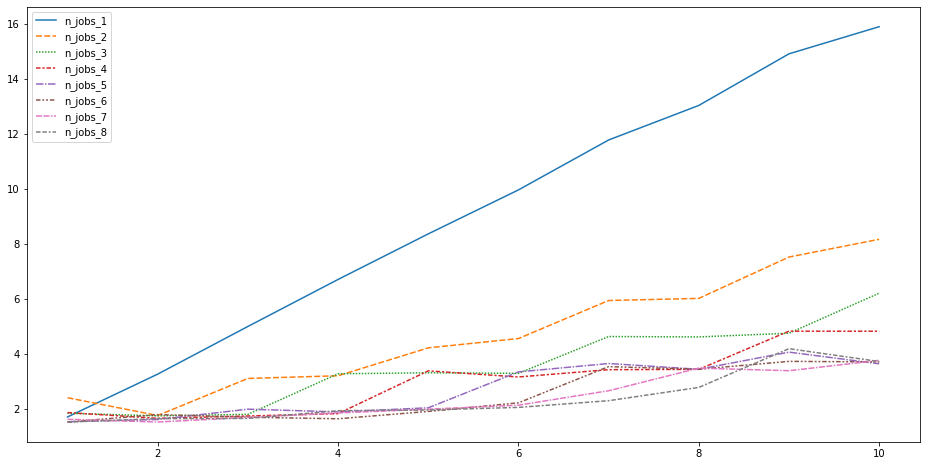

In [477]:
plt.figure(figsize=(16, 8))
sns.lineplot(data = perf_df);

In [478]:
# just sanity check that it predicts something valid enough
model = MyRandomForestClassifier(n_estimators=10, n_jobs = 8)
model.fit(X_train, y_train)

In [479]:
model.predict(X_test)

array([1., 1., 1., 0., 0., 0., 1., 0., 1., 1., 1., 1., 1., 0., 0., 1., 1.,
       1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 1., 1.,
       1., 0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 0., 1., 1., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 1., 1., 1.,
       0., 1., 0., 0., 1., 1., 1., 0., 1., 0., 0., 1., 0., 1., 0., 1., 1.,
       0., 1., 0., 0., 1., 1., 0., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1.,
       1., 0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0.,
       0., 1., 1., 1., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 1., 0., 1., 1., 0., 1., 1., 1., 0., 1., 0., 1., 0., 0., 1., 1.,
       1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 0.,
       1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0.])

In [480]:
print(f"Accuracy score is: {accuracy_score(y_test, model.predict(X_test))}")

Accuracy score is: 0.905
